# hyperparameter tuning for SVC


In [4]:
import optuna

In [79]:
from sklearn.svm import SVC
import utils
import pandas as pd
from sklearn.metrics import roc_auc_score,f1_score,roc_curve,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('cleaned_data.csv')
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target',scale='standard')

In [13]:
def objective (trail):
    params={
 'C': trail.suggest_float('C',1e-3,1e3,log=True),
 'class_weight': trail.suggest_categorical('class_weight',['balanced',None]) ,
 'decision_function_shape': trail.suggest_categorical('decision_function_shape',['ovo','ovr']),
 'degree': trail.suggest_int('degree',1,8),
 'gamma': trail.suggest_float('gamma',1e-3,1e3,log=True),
 'kernel': trail.suggest_categorical('kernel',['linear','poly','rbf','sigmoid']),
 'shrinking': trail.suggest_categorical('shrinking',[True,False]),

 }
    model=  SVC(**params ,random_state=42,probability=True)
    model.fit(Xtrain,ytrain)
    proba=model.predict_proba(Xtest)[:,1]
    return roc_auc_score(ytest,proba)

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-11-02 20:14:28,357] A new study created in memory with name: no-name-3b76d2d7-6b81-4f9c-8d40-bd46b1c388f5
[I 2025-11-02 20:14:28,731] Trial 0 finished with value: 0.8124772423837845 and parameters: {'C': 560.3941991509942, 'class_weight': None, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1.4137766670391962, 'kernel': 'poly', 'shrinking': False}. Best is trial 0 with value: 0.8124772423837845.
[I 2025-11-02 20:14:28,873] Trial 1 finished with value: 0.12185944896225272 and parameters: {'C': 0.0018009626296563467, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': 6, 'gamma': 2.7897204621870038, 'kernel': 'rbf', 'shrinking': False}. Best is trial 0 with value: 0.8124772423837845.
[I 2025-11-02 20:14:28,940] Trial 2 finished with value: 0.7742444471416434 and parameters: {'C': 0.15810686738304192, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': 6, 'gamma': 160.76034186470085, 'kernel': 'sigmoid', 'shrinking': True}. Best is 

In [16]:
study.best_value

0.9455637820123801

In [18]:
result = study.trials_dataframe()

In [27]:
study.best_params

{'C': 5.034504350702422,
 'class_weight': None,
 'decision_function_shape': 'ovo',
 'degree': 4,
 'gamma': 0.06475172356992681,
 'kernel': 'rbf',
 'shrinking': False}

In [38]:
import altair as alt
alt.Chart(result).mark_point().encode(
    x=alt.X('params_C',scale=alt.Scale(type='log'))
    ,y='value'
)

alt.Chart(...)

for lower C the model perform well

In [36]:
alt.Chart(result).mark_point().encode(
    x=alt.X('params_gamma',scale=alt.Scale(type='log'))
    ,y='value'
)

alt.Chart(...)

lower gamma is better choice for the model

In [37]:
alt.Chart(result).mark_point().encode(
    x='params_degree'
    ,y='value'
)

alt.Chart(...)

In [40]:
alt.Chart(result).mark_bar().encode(
    x='params_kernel'
    ,y='value'
    ,
)

alt.Chart(...)

kernel rbf is the best for the model

In [42]:
import json
with open('best_params_svc.json','w') as f:
    json.dump(study.best_params,f)

In [55]:
model=  SVC(random_state=42,probability=True)
best=  SVC(**study.best_params ,random_state=42,probability=True)


In [56]:
model.fit(Xtrain,ytrain)
best.fit(Xtrain,ytrain)


SVC(C=5.034504350702422, decision_function_shape='ovo', degree=4,
    gamma=0.06475172356992681, probability=True, random_state=42,
    shrinking=False)

In [57]:
proba_base = model.predict_proba(Xtest)[:,1]
proba_best = best.predict_proba(Xtest)[:,1]
fp_base,tp_base,_ =roc_curve(ytest,proba_base)
fp_best,tp_best,_ =roc_curve(ytest,proba_best)



In [75]:
s=alt.Chart(pd.DataFrame({'0':[0,1],'1':[0,1]})).mark_line(
    color='red',
   strokeDash=[5,5]
).encode(
    x='0',
    y='1'
)
roc_base=alt.Chart(pd.DataFrame({'fp':fp_base,'tp':tp_base})).mark_line().encode(
    x='fp',
    y='tp'
)+s
roc_best=alt.Chart(pd.DataFrame({'fp':fp_best,'tp':tp_best})).mark_line().encode(
    x='fp',
    y='tp'
)+s



In [76]:
roc_base.properties(title='base model')|roc_best.properties(title='best model')

alt.HConcatChart(...)

Threshold tuning

In [88]:
import numpy as np

In [100]:
thresholds=np.arange(0,1,0.001)
f1_base=[]
f1_best=[]
for threshold in thresholds:
    pred_base=(proba_base>threshold).astype(int)
    pred_best=(proba_best>threshold).astype(int)
    f1_base.append(f1_score(ytest,pred_base))
    f1_best.append(f1_score(ytest,pred_best))

In [101]:
np.max(f1_base),np.max(f1_best)

(np.float64(0.9041095890410958), np.float64(0.9012875536480687))

In [102]:
threshold_base=thresholds[np.argmax(f1_base)]
threshold_best=thresholds[np.argmax(f1_best)]
threshold_base,threshold_best

(np.float64(0.399), np.float64(0.23500000000000001))

In [103]:
pred_base=(proba_base>threshold_base).astype(int)
pred_best=(proba_best>threshold_best).astype(int)
cm_base=pd.DataFrame(confusion_matrix(ytest,pred_base),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])
cm_best=pd.DataFrame(confusion_matrix(ytest,pred_best),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])


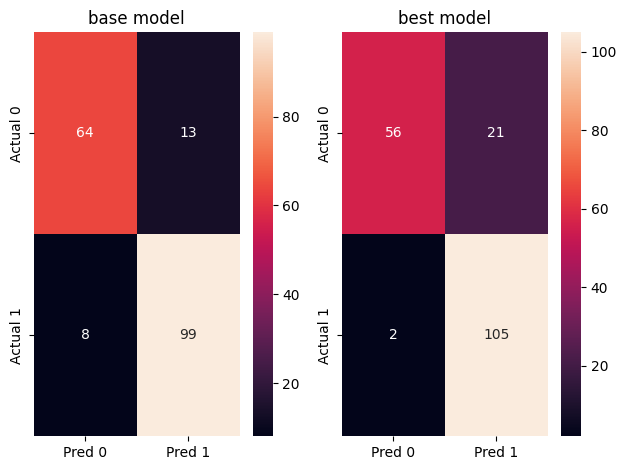

In [104]:
plt.subplot(1,2,1)
sns.heatmap(cm_base,annot=True,fmt='d')
plt.title('base model')
plt.subplot(1,2,2)
sns.heatmap(cm_best,annot=True,fmt='d')
plt.title('best model')
plt.tight_layout()